In [28]:
import seaborn as sns
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

## Extract results from log files and create a dataframe

In [29]:
method_folder = ['all_drugs_with_error_bar', 'moli','holi_only__more_sobol', 'holi_moli_saasbo_50_sobol',
                 'holi_moli_gp_30_sobol']
logfile_name = 'logs.txt'
result_dataframe = pd.DataFrame(columns=['Drug', 'Dataset', 'Auroc', 'Method', 'Hours'])
result_path = Path('..', 'results', 'bayesian_optimisation')

drug_paths =  [x for x in result_path.iterdir()]
for drug_path in drug_paths:
    drug = drug_path.stem
    if drug in ('EGFR', 'ensemble'):
        continue
    for logfile_folder in method_folder:
        method = logfile_folder
        log_path = drug_path / logfile_folder / logfile_name
        if log_path.is_file():
            with open(log_path, 'r') as log_file:
                test_auroc =[]
                extern_auroc = []
                for line in log_file:
                    if 'test Auroc' in line:
                        test_auroc.append(float(line.split("=")[-1].strip()))
                    if 'extern AUROC' in line:
                        extern_auroc.append(float(line.split("=")[-1].strip()))
                    if 'Minutes' in line:
                        time_hours = int(int(line.split(":")[-1].strip()) / 60)
                for auroc in test_auroc:
                    result_dataframe = result_dataframe.append(
                        pd.DataFrame([[drug, 'Test', auroc, method, time_hours]],
                                         columns=['Drug', 'Dataset', 'Auroc', 'Method', 'Hours']))
                for auroc in extern_auroc:
                    result_dataframe = result_dataframe.append(
                        pd.DataFrame([[drug, 'Extern', auroc, method, time_hours]],
                                         columns=['Drug', 'Dataset', 'Auroc', 'Method', 'Hours']))

## Get ensemble results

In [31]:
ensemble_path = result_path / 'ensemble'
method_paths = ['bo-holimoli-ensemble']

for method_path in method_paths:
    drug_paths =  [x for x in (ensemble_path / method_path).iterdir()]
    for drug_path in drug_paths:
        drug = drug_path.stem
        log_path = drug_path / logfile_name
        if log_path.is_file():
            with open(log_path, 'r') as log_file:
                for line in log_file:
                    if 'Soft' in line:
                        soft_auroc = float(line.split("=")[-1].strip())
                        result_dataframe = result_dataframe.append(
                        pd.DataFrame([[drug, 'Extern', soft_auroc, method_path, 0]],
                                         columns=['Drug', 'Dataset', 'Auroc', 'Method', 'Hours']))
                    if 'Weighted' in line:
                        weighted_auroc = float(line.split("=")[-1].strip())
                        result_dataframe = result_dataframe.append(
                        pd.DataFrame([[drug, 'Extern', weighted_auroc, method_path, 0]],
                                         columns=['Drug', 'Dataset', 'Auroc', 'Method', 'Hours']))

## Beautify strings

In [33]:
result_dataframe = result_dataframe.replace('all_drugs_with_error_bar', 'Bo-Holi-MOLI')
result_dataframe = result_dataframe.replace('holi_only__more_sobol', 'Random-Holi-MOLI')
result_dataframe = result_dataframe.replace('moli', 'MOLI')
result_dataframe = result_dataframe.replace('holi_moli_saasbo_50_sobol', 'SAASBO')
result_dataframe = result_dataframe.replace('holi_moli_gp_30_sobol', 'Hol-Moli-v2')

result_dataframe = result_dataframe.replace('Gemcitabine_pdx', 'Gemcitabine with PDX')
result_dataframe = result_dataframe.replace('Gemcitabine_tcga', 'Gemcitabine with TCGA')
result_dataframe.to_csv('results')

## Plot categorical boxplots

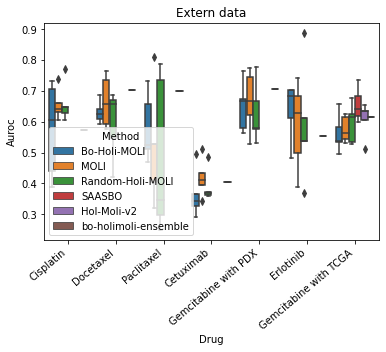

In [34]:
test_results = result_dataframe[result_dataframe['Dataset'] == 'Test']
extern_results = result_dataframe[result_dataframe['Dataset'] == 'Extern']
boxplot_test = sns.boxplot(x='Drug', y='Auroc', hue='Method',  data=test_results)
boxplot_test.set_xticklabels(boxplot_test.get_xticklabels(), rotation=40, ha="right")
plt.title('Test data')
plt.savefig('boxplot_test.pdf', bbox_inches="tight")
plt.clf()

boxplot_extern = sns.boxplot(x='Drug', y='Auroc', hue='Method',  data=extern_results)
boxplot_extern.set_xticklabels(boxplot_extern.get_xticklabels(), rotation=40, ha="right")
plt.title('Extern data')
plt.savefig('boxplot_extern.pdf', bbox_inches="tight")

## Show time differences